In [1]:
pip install --user kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --user pyxlsb


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import kagglehub
import os
import pandas as pd
from tensorflow.data import AUTOTUNE
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2025-09-30 00:53:49.504565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759208029.685829 1056977 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759208029.731651 1056977 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759208030.234480 1056977 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759208030.234510 1056977 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759208030.234513 1056977 computation_placer.cc:177] computation placer alr

In [2]:
attributes_df = pd.read_excel("list_attr_celeba_with_identity.xlsb", engine='pyxlsb')

In [3]:
print(f"Original dataset size: {len(attributes_df)}")
attributes_df = attributes_df.dropna(subset=['image_id', 'Celeb_identity'])
print(f"After removing missing values: {len(attributes_df)}")


Original dataset size: 1048575
After removing missing values: 202599


In [4]:
attributes_df['Celeb_identity'] = attributes_df['Celeb_identity'].astype(int)


In [5]:
print(f"Dataset Shape: {attributes_df.shape}")
print(f"Columns: {list(attributes_df.columns)}")
print(f"Number of unique identities: {attributes_df['Celeb_identity'].nunique()}")

Dataset Shape: (202599, 42)
Columns: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'Celeb_identity']
Number of unique identities: 10177


In [6]:
train_dir = kagglehub.dataset_download("jessicali9530/celeba-dataset")  # Download dataset
image_dir = os.path.join(train_dir, "img_align_celeba", "img_align_celeba")  # Path to images

In [7]:
# Prepare image paths and labels
image_paths = [os.path.join(image_dir, img_name) for img_name in attributes_df['image_id']]

# Encode identity labels to integers (0 to num_classes-1)
label_encoder = LabelEncoder()
identity_labels = label_encoder.fit_transform(attributes_df['Celeb_identity'])
num_classes = len(label_encoder.classes_)

print(f"Total images: {len(image_paths)}")
print(f"Number of classes (identities): {num_classes}")
print(f"Original identity range: {attributes_df['Celeb_identity'].min()} to {attributes_df['Celeb_identity'].max()}")
print(f"Encoded label range: {identity_labels.min()} to {identity_labels.max()}")


Total images: 202599
Number of classes (identities): 10177
Original identity range: 1 to 10177
Encoded label range: 0 to 10176


In [8]:
# to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, identity_labels))

# Apply preprocessing
dataset = dataset.map(
    load_and_preprocess_image, 
    num_parallel_calls=AUTOTUNE
)

# Split into train/validation (80/20 split)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Shuffle and split
dataset = dataset.shuffle(buffer_size=10000, seed=42)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and prefetch for training
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

# Optional: Cache datasets to speed up training (if you have enough memory/storage)
# train_dataset = train_dataset.cache()
# val_dataset = val_dataset.cache()

# Verify the dataset
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Label range: {tf.reduce_min(labels)} to {tf.reduce_max(labels)}")
    break

I0000 00:00:1759208251.916199 1056977 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Training batches: 5065
Validation batches: 1267
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)
Label range: 39 to 10031


## Models

### Baseline CNN for entire dataset

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

def create_baseline_cnn(num_classes, input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        #layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model



In [10]:
# Create the model
print("Creating baseline CNN model...")
baseline_model = create_baseline_cnn(num_classes)
print("Model Architecture:")
baseline_model.summary()

Creating baseline CNN model...


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10177)          │     2,615,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,856,257 (29.97 MB)

 Trainable params: 7,855,297 (29.97 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
# Compile the model
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] 
)

print(f"Model compiled successfully!")
print(f"Total parameters: {baseline_model.count_params():,}")



Model compiled successfully!
Total parameters: 7,856,257


In [13]:
# Training configuration
EPOCHS = 30 
EARLY_STOPPING_PATIENCE = 10

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ### tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_loss',
        #factor=0.5,
       # patience=3,
      #  min_lr=1e-7,
     #   verbose=1
    #),
    #tf.keras.callbacks.ModelCheckpoint(
        #filepath='baseline_cnn_best.h5',
       # monitor='val_accuracy',
      #  save_best_only=True,
     #   verbose=1
    #) 
]
# Start training
history = baseline_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining completed!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 119s 23ms/step - accuracy: 1.5106e-04 - loss: 8.8998 - val_accuracy: 0.0000e+00 - val_loss: 15.0083
Epoch 2/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 117s 23ms/step - accuracy: 2.0161e-04 - loss: 8.9001 - val_accuracy: 2.4679e-05 - val_loss: 15.1309
Epoch 3/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 114s 22ms/step - accuracy: 1.8687e-04 - loss: 8.9006 - val_accuracy: 4.9358e-05 - val_loss: 15.2218
Epoch 4/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - accuracy: 2.1047e-04 - loss: 8.9013 - val_accuracy: 2.4679e-05 - val_loss: 15.3077
Epoch 5/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 115s 23ms/step - accuracy: 1.3856e-04 - loss: 8.9018 - val_accuracy: 4.9358e-05 - val_loss: 15.3720
Epoch 6/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 114s 22ms/step - accuracy: 2.4494e-04 - loss: 8.9022 - val_accuracy: 0.0000e+00 - val_loss: 15.4290
Epoch 7/30
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 113s 22ms/step - accuracy: 3.3302e-04 - loss: 8.9024 - val_accuracy: 0.0000e+00 - val_loss: 15.4714
Epoch 

### Improved CNN

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
def improved_baseline_cnn(num_classes, input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(), 
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        #layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [10]:
# Create the model
print("Creating improved baseline CNN model...")
imp_baseline_model = improved_baseline_cnn(num_classes)
print("Model Architecture:")
imp_baseline_model.summary()

Creating improved baseline CNN model...


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 8,604,417 (32.82 MB)

 Trainable params: 8,600,449 (32.81 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [11]:
imp_baseline_model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
print("Model compiled successfully!")
print(f"Total Parameters: {imp_baseline_model.count_params():,}")

Model compiled successfully!
Total Parameters: 8,604,417


In [12]:
# Training configuration
EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5
2
# Callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
]
# Start training
history = imp_baseline_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining completed!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/20


I0000 00:00:1759194044.893532  509380 service.cc:152] XLA service 0x14765c055a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759194044.893557  509380 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-09-29 21:00:45.031362: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759194045.754856  509380 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-29 21:00:47.120499: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.21 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.21391, f32[64,3,3,3]{3,2,1,0} %bitcast.20781, f32[64]{0} %bitcast.22285), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

   2/5065 ━━━━━━━━━━━━━━━━━━━━ 6:04 72ms/step - accuracy: 0.0000e+00 - loss: 9.2400   

I0000 00:00:1759194058.371273  509380 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5064/5065 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.2384e-04 - loss: 9.1166

2025-09-29 21:06:16.107385: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.21 = (f32[31,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,3,128,128]{3,2,1,0} %bitcast.21391, f32[64,3,3,3]{3,2,1,0} %bitcast.20781, f32[64]{0} %bitcast.22285), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:06:16.194016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted po

5065/5065 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.2383e-04 - loss: 9.1166

2025-09-29 21:07:04.154744: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.21 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.901, f32[64,3,3,3]{3,2,1,0} %bitcast.908, f32[64]{0} %bitcast.910), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-29 21:07:04.264927: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentia

5065/5065 ━━━━━━━━━━━━━━━━━━━━ 411s 77ms/step - accuracy: 1.2383e-04 - loss: 9.1166 - val_accuracy: 0.0000e+00 - val_loss: 69.6161
Epoch 2/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 377s 74ms/step - accuracy: 1.8829e-04 - loss: 8.9259 - val_accuracy: 0.0000e+00 - val_loss: 12.6136
Epoch 3/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 379s 74ms/step - accuracy: 2.3907e-04 - loss: 8.9068 - val_accuracy: 2.4679e-05 - val_loss: 13.5689
Epoch 4/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 377s 74ms/step - accuracy: 1.6791e-04 - loss: 8.9014 - val_accuracy: 2.4679e-05 - val_loss: 14.2486
Epoch 5/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 375s 74ms/step - accuracy: 1.9904e-04 - loss: 8.9000 - val_accuracy: 2.4679e-05 - val_loss: 14.6279
Epoch 6/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 375s 74ms/step - accuracy: 1.7450e-04 - loss: 8.9000 - val_accuracy: 7.4038e-05 - val_loss: 14.8605
Epoch 7/20
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 377s 74ms/step - accuracy: 1.7456e-04 - loss: 8.9005 - val_accuracy: 7.4038e-05 - val_loss: 15.0207
Epoch 8/20
5065/5

### CNN for top 1000 frequency identities

In [9]:
top_n = 1000
top_identities = pd.Series(identity_labels).value_counts().head(top_n).index
print(f"Taking top {top_n} identities (out of {num_classes})")

Taking top 1000 identities (out of 10177)


In [10]:
mask = np.isin(identity_labels, top_identities)
filtered_attributes_df = attributes_df[mask].copy()
print(f"Filtered dataset size: {len(filtered_attributes_df)} images")


Filtered dataset size: 30038 images


In [11]:
# Re-encode labels to be continuous 0 to n-1
filtered_identity_labels = filtered_attributes_df['Celeb_identity'].values
label_encoder_filtered = LabelEncoder()
filtered_encoded_labels = label_encoder_filtered.fit_transform(filtered_identity_labels)
num_classes_filtered = len(label_encoder_filtered.classes_)

print(f"New number of classes: {num_classes_filtered}")

New number of classes: 1000


In [12]:
# Create new dataset with filtered data
filtered_image_paths = [os.path.join(image_dir, img_name) for img_name in filtered_attributes_df['image_id']]

# Create the filtered dataset
filtered_dataset = tf.data.Dataset.from_tensor_slices((filtered_image_paths, filtered_encoded_labels))
filtered_dataset = filtered_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Split filtered dataset
filtered_total_size = len(filtered_image_paths)
filtered_train_size = int(0.8 * filtered_total_size)

filtered_dataset = filtered_dataset.shuffle(buffer_size=10000, seed=42)
filtered_train_dataset = filtered_dataset.take(filtered_train_size)
filtered_val_dataset = filtered_dataset.skip(filtered_train_size)
BATCH_SIZE = 32
filtered_train_dataset = filtered_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
filtered_val_dataset = filtered_val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Filtered training batches: {len(filtered_train_dataset)}")
print(f"Filtered validation batches: {len(filtered_val_dataset)}")


Filtered training batches: 751
Filtered validation batches: 188


In [20]:
def create_improved_baseline_cnn1000(num_classes, input_shape=(128, 128, 3)):
    model = models.Sequential([        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(), 
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [21]:
improved_model1000 = create_improved_baseline_cnn1000(num_classes_filtered)

# Compile
improved_model1000.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

improved_model1000.summary()

/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             

 Total params: 3,896,616 (14.86 MB)

 Trainable params: 3,892,648 (14.85 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [22]:
history_improved1000 = improved_model1000.fit(
    filtered_train_dataset,
    epochs = 10,
    validation_data = filtered_val_dataset,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)],
    verbose = 1
)

Epoch 1/10
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 6.1454e-04 - loss: 7.7116

2025-09-30 01:05:44.270659: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.21 = (f32[30,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,128,128]{3,2,1,0} %bitcast.20759, f32[64,3,3,3]{3,2,1,0} %bitcast.20766, f32[64]{0} %bitcast.22274), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_21_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 01:05:44.369954: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitt

751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 6.1489e-04 - loss: 7.7111

2025-09-30 01:06:02.216046: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.21 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.883, f32[64,3,3,3]{3,2,1,0} %bitcast.890, f32[64]{0} %bitcast.892), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_21_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 01:06:02.329597: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot

751/751 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 6.1523e-04 - loss: 7.7107 - val_accuracy: 9.9867e-04 - val_loss: 6.8737
Epoch 2/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.0021 - loss: 6.8766 - val_accuracy: 0.0012 - val_loss: 6.9169
Epoch 3/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.0022 - loss: 6.7729 - val_accuracy: 0.0020 - val_loss: 6.6893
Epoch 4/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.0021 - loss: 6.7097 - val_accuracy: 0.0042 - val_loss: 6.6381
Epoch 5/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.0020 - loss: 6.6429 - val_accuracy: 0.0047 - val_loss: 6.5977
Epoch 6/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.0021 - loss: 6.5809 - val_accuracy: 0.0063 - val_loss: 6.4662
Epoch 7/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.0039 - loss: 6.5161 - val_accuracy: 0.0072 - val_loss: 6.3928
Epoch 8/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.0054 - loss: 6.4194 - va

In [24]:
print(f"\nTraining completed!")
print(f"Final training accuracy: {history_improved1000.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_improved1000.history['val_accuracy'][-1]:.4f}")


Training completed!
Final training accuracy: 0.0077
Final validation accuracy: 0.0175


### 100 Identities

In [16]:
TOP_N_CLASSES = 100

top_identities = pd.Series(identity_labels).value_counts().head(TOP_N_CLASSES).index
mask = np.isin(identity_labels, top_identities)
working_attributes_df = attributes_df[mask].copy()
print(f"Filtered dataset size: {len(working_attributes_df)} images")


Filtered dataset size: 3038 images


In [17]:
# Re-encode labels
working_identity_labels = working_attributes_df['Celeb_identity'].values
working_label_encoder = LabelEncoder()
working_encoded_labels = working_label_encoder.fit_transform(working_identity_labels)
working_num_classes = len(working_label_encoder.classes_)

print(f"Number of classes: {working_num_classes}")
print(f"Average samples per class: {len(working_attributes_df) / working_num_classes:.1f}")

# Create dataset
working_image_paths = [os.path.join(image_dir, img_name) for img_name in working_attributes_df['image_id']]


Number of classes: 100
Average samples per class: 30.4


In [18]:
# Create the dataset
working_dataset = tf.data.Dataset.from_tensor_slices((working_image_paths, working_encoded_labels))
working_dataset = working_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Split
working_total_size = len(working_image_paths)
working_train_size = int(0.8 * working_total_size)

working_dataset = working_dataset.shuffle(buffer_size=10000, seed=42)
working_train_dataset = working_dataset.take(working_train_size).batch(64).prefetch(AUTOTUNE)
working_val_dataset = working_dataset.skip(working_train_size).batch(64).prefetch(AUTOTUNE)

print(f"Training samples: {working_train_size}")
print(f"Validation samples: {working_total_size - working_train_size}")


Training samples: 2430
Validation samples: 608


In [19]:
def create_working_baseline(num_classes):
    model = models.Sequential([
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [20]:
working_model = create_working_baseline(working_num_classes)

# Compile with proven settings
working_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Summary:")
working_model.summary()

# Setup callbacks
working_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,832,804 (33.69 MB)

 Trainable params: 8,830,820 (33.69 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [21]:
# Train the model
history = working_model.fit(
    working_train_dataset,
    epochs=20,
    validation_data=working_val_dataset,
    callbacks=working_callbacks,
    verbose=1
)

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
val_loss, val_acc = working_model.evaluate(working_val_dataset, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Random guessing would give: {1/working_num_classes:.4f} ({1/working_num_classes*100:.2f}%)")
print(f"Model improvement over random: {val_acc / (1/working_num_classes):.1f}x better")



Epoch 1/20


2025-09-30 00:47:46.310061: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[64,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0} %bitcast.17330, f32[32,3,3,3]{3,2,1,0} %bitcast.17337, f32[32]{0} %bitcast.18745), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 00:47:46.348756: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitte

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0308 - loss: 5.3558

2025-09-30 00:47:55.120035: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[62,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[62,3,128,128]{3,2,1,0} %bitcast.17328, f32[32,3,3,3]{3,2,1,0} %bitcast.17335, f32[32]{0} %bitcast.18742), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 00:47:55.164417: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitte

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.0314 - loss: 5.3431

2025-09-30 00:48:02.648584: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[64,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0} %bitcast.773, f32[32,3,3,3]{3,2,1,0} %bitcast.780, f32[32]{0} %bitcast.782), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 00:48:02.687016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pote

38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 325ms/step - accuracy: 0.0320 - loss: 5.3311 - val_accuracy: 0.0099 - val_loss: 6.7374 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1611 - loss: 3.7065 - val_accuracy: 0.0066 - val_loss: 6.1764 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3115 - loss: 2.8373 - val_accuracy: 0.0230 - val_loss: 5.7367 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4583 - loss: 2.2192 - val_accuracy: 0.0230 - val_loss: 6.8346 - learning_rate: 0.0010
Epoch 5/20
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6312 - loss: 1.6577
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6302 - loss: 1.6580 - val_accuracy: 0.0181 - val_loss: 5.8001 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7285 - loss: 1.1912 - val_accuracy: 0.0


 Training history saved as 'baseline_training_history.png'


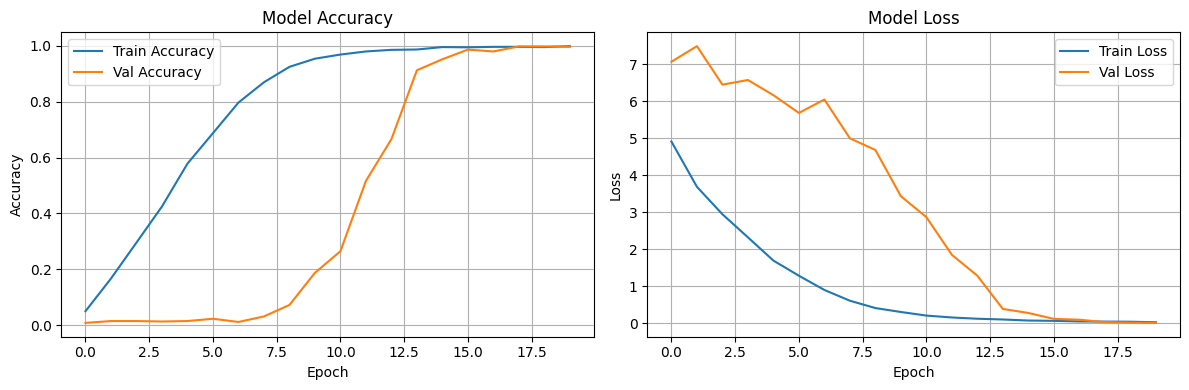

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('baseline_training_history.png', dpi=150)
print("\n Training history saved as 'baseline_training_history.png'")

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict_celebrity(image_path, model, label_encoder, top_k=5):
    
    # Load and preprocess the image
    print(f"Loading image: {image_path}")
    
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize to model input size
    image = tf.image.resize(image, [128, 128])
    
    # Normalize to [0, 1] (same as training)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Add batch dimension
    image_batch = tf.expand_dims(image, 0)
    
    print(f"Image preprocessed - shape: {image_batch.shape}")
    
    # Make prediction
    predictions = model.predict(image_batch, verbose=0)
    
    # Get top K predictions
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
    
    # Convert back to original celebrity IDs
    top_k_celeb_ids = label_encoder.inverse_transform(top_k_indices)
    
    # Prepare results
    results = []
    print(f"\n{'='*60}")
    print(f"Top {top_k} Predictions:")
    print(f"{'='*60}")
    
    for i, (celeb_id, prob) in enumerate(zip(top_k_celeb_ids, top_k_probs)):
        results.append((celeb_id, prob))
        print(f"{i+1}. Celebrity ID: {celeb_id} - Confidence: {prob*100:.2f}%")
    
    # Visualize the prediction
    plt.figure(figsize=(10, 4))
    
    # Show the input image
    plt.subplot(1, 2, 1)
    img_display = tf.io.read_file(image_path)
    img_display = tf.image.decode_jpeg(img_display, channels=3)
    plt.imshow(img_display.numpy())
    plt.title(f"Input Image\nPredicted: Celebrity ID {results[0][0]}")
    plt.axis('off')
    
    # Show confidence bar chart
    plt.subplot(1, 2, 2)
    celeb_labels = [f"ID {cid}" for cid, _ in results]
    confidences = [prob * 100 for _, prob in results]
    colors = ['green' if i == 0 else 'blue' for i in range(len(results))]
    
    plt.barh(celeb_labels, confidences, color=colors)
    plt.xlabel('Confidence (%)')
    plt.title(f'Top {top_k} Predictions')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()
    
    # Add percentage labels on bars
    for i, (label, conf) in enumerate(zip(celeb_labels, confidences)):
        plt.text(conf + 1, i, f'{conf:.1f}%', va='center')
    
    plt.tight_layout()
    plt.savefig('prediction_result.png', dpi=150, bbox_inches='tight')
    print(f"\n Prediction visualization saved as 'prediction_result.png'")
    plt.show()
    
    return results


def predict_from_dataset(dataset, model, label_encoder, num_samples=5):
  
    print(f"Predicting on {num_samples} random samples from validation set\n")
    
    # Get a batch from dataset
    for images, true_labels in dataset.take(1):
        # Select random samples
        indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
        
        fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
        if num_samples == 1:
            axes = [axes]
        
        for idx, sample_idx in enumerate(indices):
            image = images[sample_idx]
            true_label = true_labels[sample_idx].numpy()
            
            # Make prediction
            image_batch = tf.expand_dims(image, 0)
            predictions = model.predict(image_batch, verbose=0)
            predicted_label = np.argmax(predictions[0])
            confidence = predictions[0][predicted_label] * 100
            
            # Get celebrity IDs
            true_celeb_id = label_encoder.inverse_transform([true_label])[0]
            pred_celeb_id = label_encoder.inverse_transform([predicted_label])[0]
            
            # Plot
            axes[idx].imshow(image.numpy())
            
            is_correct = true_label == predicted_label
            color = 'green' if is_correct else 'red'
            result = '✓' if is_correct else '✗'
            
            axes[idx].set_title(
                f"{result} True: ID {true_celeb_id}\n"
                f"Pred: ID {pred_celeb_id}\n"
                f"Conf: {confidence:.1f}%",
                color=color,
                fontsize=10,
                fontweight='bold'
            )
            axes[idx].axis('off')
            
            print(f"Sample {idx+1}: True ID={true_celeb_id}, Predicted ID={pred_celeb_id}, "
                  f"Confidence={confidence:.1f}% - {'CORRECT' if is_correct else 'WRONG'}")
        
        plt.tight_layout()
        plt.savefig('validation_predictions.png', dpi=150, bbox_inches='tight')
        print(f"\n Validation predictions saved as 'validation_predictions.png'")
        plt.show()
        break




INTERACTIVE PREDICTION


Enter the path to the celebrity image:  018144.jpg


Loading image: 018144.jpg
Image preprocessed - shape: (1, 128, 128, 3)


2025-09-30 00:49:31.323697: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.12 = (f32[1,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128]{3,2,1,0} %bitcast.467, f32[32,3,3,3]{3,2,1,0} %bitcast.474, f32[32]{0} %bitcast.476), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-09-30 00:49:31.351887: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potent


Top 5 Predictions:
1. Celebrity ID: 2820 - Confidence: 96.24%
2. Celebrity ID: 8562 - Confidence: 1.14%
3. Celebrity ID: 7154 - Confidence: 0.84%
4. Celebrity ID: 3782 - Confidence: 0.51%
5. Celebrity ID: 6502 - Confidence: 0.19%

 Prediction visualization saved as 'prediction_result.png'


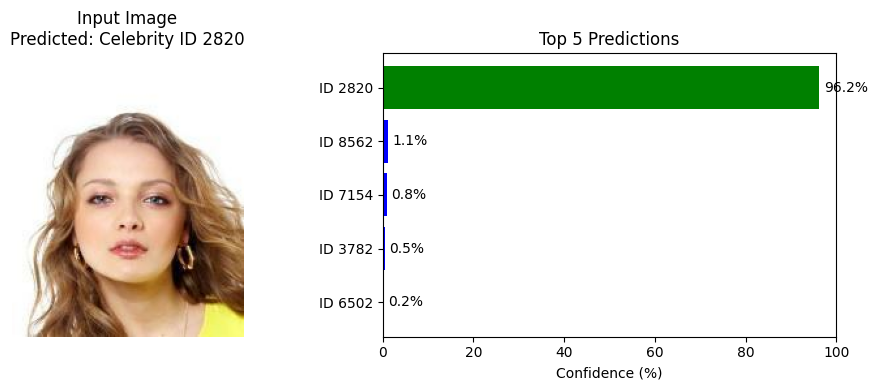

[(2820, 0.9624102),
 (8562, 0.011353917),
 (7154, 0.008432395),
 (3782, 0.005096245),
 (6502, 0.0019194008)]

In [23]:
def predict_interactive():

    print("\n" + "="*60)
    print("INTERACTIVE PREDICTION")
    print("="*60)
    
    image_path = input("Enter the path to the celebrity image: ").strip()
    
    try:
        results = predict_celebrity(
            image_path=image_path,
            model=working_model,
            label_encoder=working_label_encoder,
            top_k=5
        )
        return results
    except Exception as e:
        print(f" Error: {e}")
        print("Please check the image path and try again.")
        return None

predict_interactive()